In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
project_name='cifar10-resnet'

In [3]:
#Download the dataset
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)


['labels.txt', 'test', 'train']
['frog', 'bird', 'airplane', 'deer', 'horse', 'ship', 'cat', 'truck', 'dog', 'automobile']


# Data Normalization and Data Augmentation

There are a few important changes we'll make while creating the PyTorch datasets:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.
3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

In [4]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
#first tuple contains mean values of 3 labels (red ,blue and green) & second contains S.D(standard deviation).
train_tfms = tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect')
                        ,tt.RandomHorizontalFlip()
                        ,tt.ToTensor()
                        ,tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [5]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [6]:
batch_size = 400

In [7]:
# PyTorch data loaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_loader = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [8]:
#Let's visualize a batch of data
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

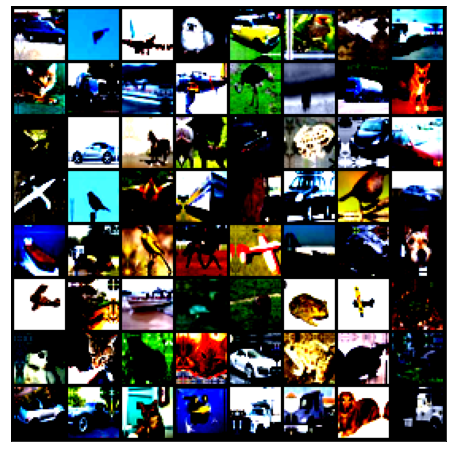

In [9]:
show_batch(train_loader)

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Let's first create a very simple residual block to see how the things work

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,3,kernel_size=3,padding=1,stride=1)
        self.relu1=nn.ReLU()
        self.conv2=nn.Conv2d(3,3,kernel_size=3,padding=1,stride=1)
        self.relu2=nn.ReLU()
    
    def forward(self,x):
        out=self.conv1(x)
        out=self.relu1(out)
        out=self.conv2(out)
        return self.relu2(out) + x # we are just adding initial x with the final output
        # ReLU can be applied before or after adding the input


In [14]:
simple_resnet = to_device(ResidualBlock(), device)

for images, labels in train_loader:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


In [15]:
#func to calculate accuracy
def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [16]:
#baseline archietecture of our model
class ImageClassification(nn.Module):
    def training_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        acc=accuracy(out,labels)
        return {'val_loss':loss.detach(),'val_acc':acc}
    
    def validation_epoch(self,outputs):
        batch_losses=[x['val_loss'] for x in outputs]
        epoch_loss=torch.stack(batch_losses).mean()
        batch_accs=[x['val_acc'] for x in outputs]
        epoch_acc=torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
    
    def epoch_end(self,epoch,result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        

In [17]:
#Since we have to perform convulation , batch normalization,relu and the maxpool if we want to do
#Thus we create a block of conv which performs all these methods
def conv_block(in_channels,out_channels,pool=False):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)   

In [18]:
#Now create our Resnet9 model
class Resnet9_model(ImageClassification):
    def __init__(self,in_channels,num_classes): #initial images were of 3*32*32
        super().__init__()
        self.conv1 = conv_block(in_channels,64) # 64*32*32
        self.conv2 = conv_block(64,128,pool=True) # 128*16*16
        self.res1  = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128*16*16
        
        self.conv3 = conv_block(128,256,pool=True) # 256*8*8
        self.conv4 = conv_block(256,512,pool=True) # 512*4*4
        self.res2  = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #512*4*4
        
        self.classifier=nn.Sequential(nn.MaxPool2d(4), #512*1*1
                                      nn.Flatten(),#512
                                      nn.Linear(512,num_classes))
        
    def forward(self,xb):
        out=self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [19]:
model = to_device(Resnet9_model(3, 10), device)
model


Resnet9_model(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpl

# Training the model

Before we train the model, we're going to make a bunch of small but important improvements to our fit function:

1. **Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the "One Cycle Learning Rate Policy", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

2. **Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

Our new loss function looks like this:   Loss = MSE(y_hat, y) + wd * sum(w^2)**

When we update weights using gradient descent we do the following:
    **w(t) = w(t-1) - lr * dLoss / dw**

3. **Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple yet effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48

In [20]:
#Since we have bulid all the components of our model ,its time to evaluate and train our model
@torch.no_grad()
def evaluate(model,val_loader):#this fnc is used to evaluate validation-set
    model.eval()
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch(outputs)

def get_lr(optimizer): # this function is used to get lr back
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs,model,train_loader,val_loader,max_lr,weight_decay=0,grad_clip=None,opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()#used to clear un-necessary cache data in gpu
    history=[]
    # Set up cutom optimizer with weight decay
    optimizer=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
    
    # Set up one-cycle learning rate scheduler
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        #Training Phase
        model.train()
        train_losses=[]
        lrs=[]
        for batch in train_loader:
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            #gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            #record & update learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() #its just modeies lr in each step
            
        #validation phase
        result=evaluate(model,val_loader)
        result['train_loss']=torch.stack(train_losses).mean().item()
        result['lrs']=lrs
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [21]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.2988667488098145, 'val_acc': 0.09615384787321091}]

In [22]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [23]:
%%time
history += fit(epochs, model, train_loader, val_loader, 
                             max_lr,grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 1.3376, val_loss: 1.5162, val_acc: 0.5381
Epoch [1], last_lr: 0.00935, train_loss: 1.0103, val_loss: 1.6993, val_acc: 0.5078
Epoch [2], last_lr: 0.00972, train_loss: 0.8093, val_loss: 0.9059, val_acc: 0.7153
Epoch [3], last_lr: 0.00812, train_loss: 0.6251, val_loss: 0.6238, val_acc: 0.7857
Epoch [4], last_lr: 0.00556, train_loss: 0.4688, val_loss: 0.6078, val_acc: 0.8081
Epoch [5], last_lr: 0.00283, train_loss: 0.3558, val_loss: 0.3517, val_acc: 0.8804
Epoch [6], last_lr: 0.00077, train_loss: 0.2562, val_loss: 0.2927, val_acc: 0.8983
Epoch [7], last_lr: 0.00000, train_loss: 0.1919, val_loss: 0.2771, val_acc: 0.9058
CPU times: user 42.4 s, sys: 9.82 s, total: 52.2 s
Wall time: 4min 5s


In [26]:
def plot_accuracy(history):
    val_acc=[x['val_acc'] for x in history]
    plt.plot(val_acc,'-bx')
    plt.xlabel('Epochs')
    plt.ylabel('Validation set Accuracy')
    plt.title("Accuracy vs No of epochs")


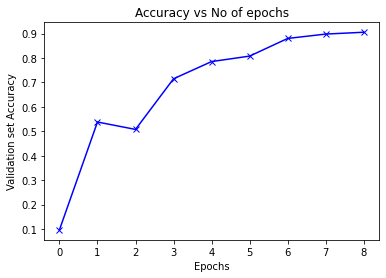

In [27]:
plot_accuracy(history)

In [30]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

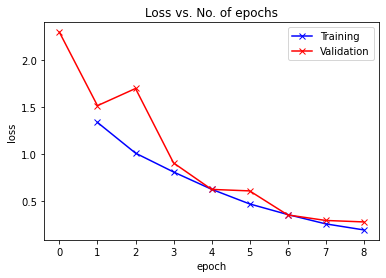

In [31]:
plot_losses(history)


In [34]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('BatchNo')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch No')

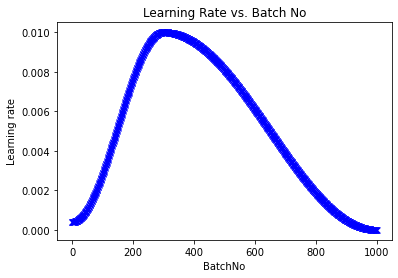

In [35]:
plot_lrs(history)